<a href="https://colab.research.google.com/github/fangnes/pucrio_data_science_and_analytics/blob/main/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discord Notes

Professor Patrick Happ says that we should try different approachs in order to determine which one suits better to our problem/dataset. He states that we could combine 6 apporachs:


*   original dataset with/without feature selection
*   normalized dataset with/without feature selection
*   standardized dataset with/without feature selection



Professor Hugo Villamizar says that some feature selection methods (like correlational analysis) are sensitive to data sacling and may not work well with a dataset that is not normalized/standardized

Professor Hugo Villamizar says that the proximity between mean and median are not enough to determine if the dataset is normalized, we must plot the dataset into a histogram in order to analyse if it is normalized, if it has a right-skewed distribution or a left-skewed distribution

# MVP Checklist

## Problem Definition

Objective: understand and clearly describe the problem being solved.

* What is the problem description?
* Do you have premises or hypotheses about the problem? Which?
* What restrictions or conditions were imposed to select the data?
* Describe your dataset (attributes, images, annotations, etc.).

## Dataset preparation

Objective: perform data preparation operations.

* Separate the dataset between training and testing (and validation, if applicable).
* Does it make sense to use a cross-validation method? Justify if you do not use it.
* Check which data transformation operations (such as normalization and standardization, transforming images into tensors) are most appropriate for your problem and save different views of your dataset for later model evaluation.
* Refine the number of available attributes, carrying out the feature selection process appropriately.

## Modeling and training

Objective: build models to solve the problem at hand.

* Select the most suitable algorithms for the chosen problem and dataset, justifying your choices.
* Are there any initial settings for the hyperparameters?
* Was the model properly trained? Has an underfitting problem been observed?
* Is it possible to optimize the hyperparameters of any of the models? If yes, do so, justifying all choices.
* Are there any advanced or more complex methods that can be evaluated?
Can I create a committee of different models for the problem (ensembles)?

## Results assessment

Objective: analyze the performance of models generated on unseen data (with the test base)

* Select the evaluation metrics consistent with the problem, justifying them.
* Train the chosen model with the entire training database, and test it with the test database.
* Do the results make sense?
* Have any overfitting issues been observed?
* Compare results from different models.
* Describe the best solution found, justifying it.

# Notebook configuration

## Installing packages

In [1]:
!pip install pandas

In [2]:
!pip install ucimlrepo

## Import packages and libraries

In [163]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd                                   # To manipulate the dataset
import numpy as np


from ucimlrepo import fetch_ucirepo                   # To load the dataset
from sklearn.model_selection import train_test_split  # To split the dataset into train and test dataset
from sklearn.model_selection import StratifiedKFold   #
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Dont know
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Ensambles
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Feature seletcion
from sklearn.feature_selection import SelectKBest     # para a Seleção Univariada
from sklearn.feature_selection import f_classif       # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE             # para a Eliminação Recursiva de Atributos

# Global variables

In [4]:
num_features = 13
target_index = 13
seed = 21
test_size = 0.2

In [5]:
np.random.seed(seed)

# Functions

In [6]:
def eval_metric_mean_std_plot(model_results, model_names):
  # @TODO: ADICIONAR NO GRÁFICO QUAL A MÉTRICA DE AVALIAÇÃO ESTÁ SENDO PLOTADA
  means = [arr.mean() for arr in model_results]
  std = [arr.std() for arr in model_results]
  models_info = list(zip(model_names, means, std))

  models_info_sorted = sorted(models_info, key=lambda x: x[1])

  names_sorted = [t[0] for t in models_info_sorted]
  means_sorted = [t[1] for t in models_info_sorted]
  std_sorted = [t[2] for t in models_info_sorted]

  for i in range(len(names_sorted)):
    print("%s: %.3f (%.3f)" % (names_sorted[i], means_sorted[i], std_sorted[i]))

  fig, ax1 = plt.subplots(figsize=(len(models_info)/1.5,6))

  color = 'tab:blue'
  ax1.set_xlabel('Models')
  ax1.set_ylabel('Evaluation Metric Mean', color=color)
  bars = ax1.bar(names_sorted, means_sorted, color=color, label='Mean')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.set_ylim(0,1)
  ax1.set_yticks([i/10 for i in range(11)])
  plt.xticks(rotation=90)

  # Put values in bar chart
  # for bar in bars:
  #   height = bar.get_height()
  #   ax1.annotate(f'{height}',
  #                xy=(bar.get_x() + bar.get_width() / 2, height),
  #                xytext=(0, 3),
  #                textcoords="offset points",
  #                ha='center', va='bottom')

  ax2 = ax1.twinx()

  color = 'tab:red'
  ax2.set_ylabel('Standar Variation', color=color)
  ax2.plot(std_sorted, marker='o', linestyle='-', color=color, label='Std var')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim(0, 0.1)
  ax2.set_yticks([i/100 for i in range(21)])

  # Put values in line chart
  # for i, txt in enumerate(std_sorted):
  #   ax2.annotate(f'{txt}',
  #                xy=(names_sorted[i], txt),
  #                xytext=(0, 5),
  #                textcoords="offset points",
  #                ha='center', va='bottom',
  #                color=color)

  # plt.title('Bar and Line Chart Example')
  fig.tight_layout()

  plt.gca().set_axisbelow(True)
  ax1.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  plt.show()

# Test
# eval_metric_mean_std_plot(results, names)

In [7]:
def cross_val_score_execution(models, X_train, y_train, kfold, scoring):
  results = []
  names = []
  for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)

  return names, results

In [8]:
def cross_validation_with_selected_features(models, df, y, features_selected, test_size, seed, num_folds, scoring):

  df_4_best_var  = df[features_selected[:3]]
  df_7_best_var  = df[features_selected[:6]]
  df_10_best_var = df[features_selected[:9]]

  X_4  = df_4_best_var.values
  X_7  = df_7_best_var.values
  X_10 = df_10_best_var.values

  X_4_train,  X_4_test,  y_4_train,  y_4_test  = train_test_split(X_4, y,  test_size=test_size, shuffle=True, random_state=seed, stratify=y)
  X_7_train,  X_7_test,  y_7_train,  y_7_test  = train_test_split(X_7, y,  test_size=test_size, shuffle=True, random_state=seed, stratify=y)
  X_10_train, X_10_test, y_10_train, y_10_test = train_test_split(X_10, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)

  # @TODO: UTILIZAR A QUANTIDADE DE FOLDS QUE TIVER O MELHOR DESEMPENHO NA PRIMEIRA EXECUÇÃO DOS MODELOS (sem pipelines)
  names_4, results_4   = cross_val_score_execution(models, X_4_train,  y_4_train,  num_folds, scoring)
  names_7, results_7   = cross_val_score_execution(models, X_7_train,  y_7_train,  num_folds, scoring)
  names_10, results_10 = cross_val_score_execution(models, X_10_train, y_10_train, num_folds, scoring)

  return names_4, results_4, names_7, results_7, names_10, results_10

In [9]:
def get_features_name_sorted_from_feature_importances(df, model):

  names_features = list(zip(df.columns[:13], model.feature_importances_))
  names_features_sorted = sorted(names_features, key=lambda x: x[1], reverse=True)

  return [x[0] for x in names_features_sorted]

# Dataset setup

## Dataset load

In [10]:
# Loading dataset
heart_disease = fetch_ucirepo(name='Heart Disease')

In [11]:
# Getting dataset features and target dataframes
X = heart_disease.data.features
y = heart_disease.data.targets

In [12]:
# Feature dataframe visual analysis
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


By taking a look into the feature dataframe, it was possible to note that we have at least one row with a NaN (Not a Number) value. This could lead our model to raise some error or have some undesired behavior, so, after make a visual analysis into the target dataframe, we must handle this issue.

In [13]:
# Target dataframe visual analysis
y

,num
0,0
1,2
2,1
3,0
4,0
...,...
298,1
299,2
300,3
301,1


In [14]:
y['num'] = y['num'].apply(lambda x: 1 if x > 0 else x)

y

,num
0,0
1,1
2,1
3,0
4,0
...,...
298,1
299,1
300,1
301,1


## Dataset cleaning

We will use the count() function to identify wich columns have NaN values:

In [15]:
X.count()

age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          299
thal        301
dtype: int64

By using the X.count() we can observe that two columns have some NaN values in the features dataframe (4 rows in "ca" column and 2 rows in "thal" column). As none of the columns has presented a expressive amount of NaN values, we will handle this issue through data removal, by removing the rows that caontains NaN values from the dataframe. However, if we drop the NaN rows directly from X dataframe, we would not be able to drop the related target class in the dataframe y, so, we will concatenate these dataframes and then drop the rows that contains NaN values.

In [16]:
# Concatenating feature and target datasets. "axis=1" means that we'll concatenate the columns.
df_heart_disease = pd.concat([X,y], axis=1)

# Checking the result
df_heart_disease

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [17]:
# Dropping NaN rows
df_heart_disease = df_heart_disease.dropna()

# Checking the result
df_heart_disease.count()

age         297
sex         297
cp          297
trestbps    297
chol        297
fbs         297
restecg     297
thalach     297
exang       297
oldpeak     297
slope       297
ca          297
thal        297
num         297
dtype: int64

Unfortunately, as we can see in the result above, the "ca" and "thal" rows with NaN didn't coincide, leaving us with the worst case scenario of 297 samples. Since we still have 98% of the original dataset, our model will not be penalyzed by this.

In [18]:
# Getting dataframe values as array
arr_heart_disease = df_heart_disease.values

# Getting features values arrays into a list
X = arr_heart_disease[:,0:num_features]

X

array([[63.,  1.,  1., ...,  3.,  0.,  6.],
       [67.,  1.,  4., ...,  2.,  3.,  3.],
       [67.,  1.,  4., ...,  2.,  2.,  7.],
       ...,
       [68.,  1.,  4., ...,  2.,  2.,  7.],
       [57.,  1.,  4., ...,  2.,  1.,  7.],
       [57.,  0.,  2., ...,  2.,  1.,  3.]])

In [19]:
# Getting target values arrays into a list
y = arr_heart_disease[:,target_index]

y

array([0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1.

# Holdout and cross validation configuration

The approach to split the dataset into train and test dataset is to train the models with 80% of the dataset and keep 20% for training.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)

In [21]:
three_folds = StratifiedKFold(n_splits=3,  shuffle=True, random_state=seed)
five_folds  = StratifiedKFold(n_splits=5,  shuffle=True, random_state=seed)
ten_folds   = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [22]:
baggingEstimator = DecisionTreeClassifier()
num_trees = 100
max_features = 8
max_iter = 200

bases = [
    ('Logistic', LogisticRegression(max_iter=max_iter)),
    ('CART', DecisionTreeClassifier()),
    ('SVM', SVC())
]


models = [
    ('LR', LogisticRegression(max_iter=max_iter)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('Bagging', BaggingClassifier(estimator=baggingEstimator, n_estimators=num_trees)),
    ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)),
    ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)),
    ('Ada', AdaBoostClassifier(n_estimators=num_trees)),
    ('GB', GradientBoostingClassifier(n_estimators=num_trees)),
    ('Voting', VotingClassifier(bases))
]

In [23]:
scoring = 'recall'
names, results = cross_val_score_execution(models, X_train, y_train, ten_folds, scoring)

SVM: 0.458 (0.189)
KNN: 0.605 (0.160)
CART: 0.695 (0.122)
GB: 0.705 (0.098)
Bagging: 0.724 (0.086)
RF: 0.733 (0.107)
ET: 0.742 (0.131)
Voting: 0.743 (0.128)
Ada: 0.752 (0.101)
NB: 0.789 (0.100)
LR: 0.808 (0.085)


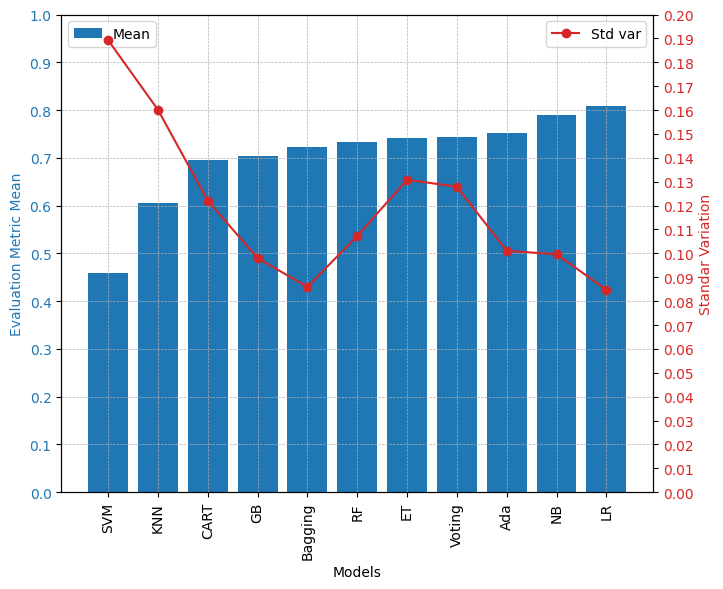

In [24]:
eval_metric_mean_std_plot(results, names)

In [25]:
np.random.seed(seed)
# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
svm = ('SVM', SVC())
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
reg_log = ('LR', LogisticRegression(max_iter=max_iter))
naive_bayes = ('NB', GaussianNB())

# Ensambles
voting = ('Voting', VotingClassifier(bases))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
bagging = ('Bag', BaggingClassifier(estimator=baggingEstimator, n_estimators=num_trees))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))


pip_names, pip_results = cross_val_score_execution(pipelines, X_train, y_train, ten_folds, scoring)

SVM-orig: 0.458 (0.189)
KNN-orig: 0.605 (0.160)
CART-orig: 0.695 (0.122)
CART-norm: 0.705 (0.127)
GB-orig: 0.705 (0.098)
GB-padr: 0.714 (0.111)
GB-norm: 0.714 (0.111)
CART-padr: 0.723 (0.147)
Bag-orig: 0.724 (0.086)
Bag-norm: 0.724 (0.086)
ET-padr: 0.732 (0.144)
RF-norm: 0.732 (0.112)
RF-orig: 0.733 (0.107)
ET-orig: 0.742 (0.131)
Vot-orig: 0.743 (0.128)
Bag-padr: 0.751 (0.112)
RF-padr: 0.751 (0.112)
Ada-orig: 0.752 (0.101)
Ada-padr: 0.752 (0.101)
ET-norm: 0.752 (0.123)
Ada-norm: 0.752 (0.101)
KNN-padr: 0.770 (0.103)
SVM-norm: 0.781 (0.122)
Vot-norm: 0.781 (0.122)
SVM-padr: 0.788 (0.110)
NB-orig: 0.789 (0.100)
NB-padr: 0.789 (0.100)
KNN-norm: 0.789 (0.147)
NB-norm: 0.789 (0.100)
LR-padr: 0.790 (0.114)
LR-norm: 0.790 (0.121)
Vot-padr: 0.798 (0.098)
LR-orig: 0.808 (0.085)


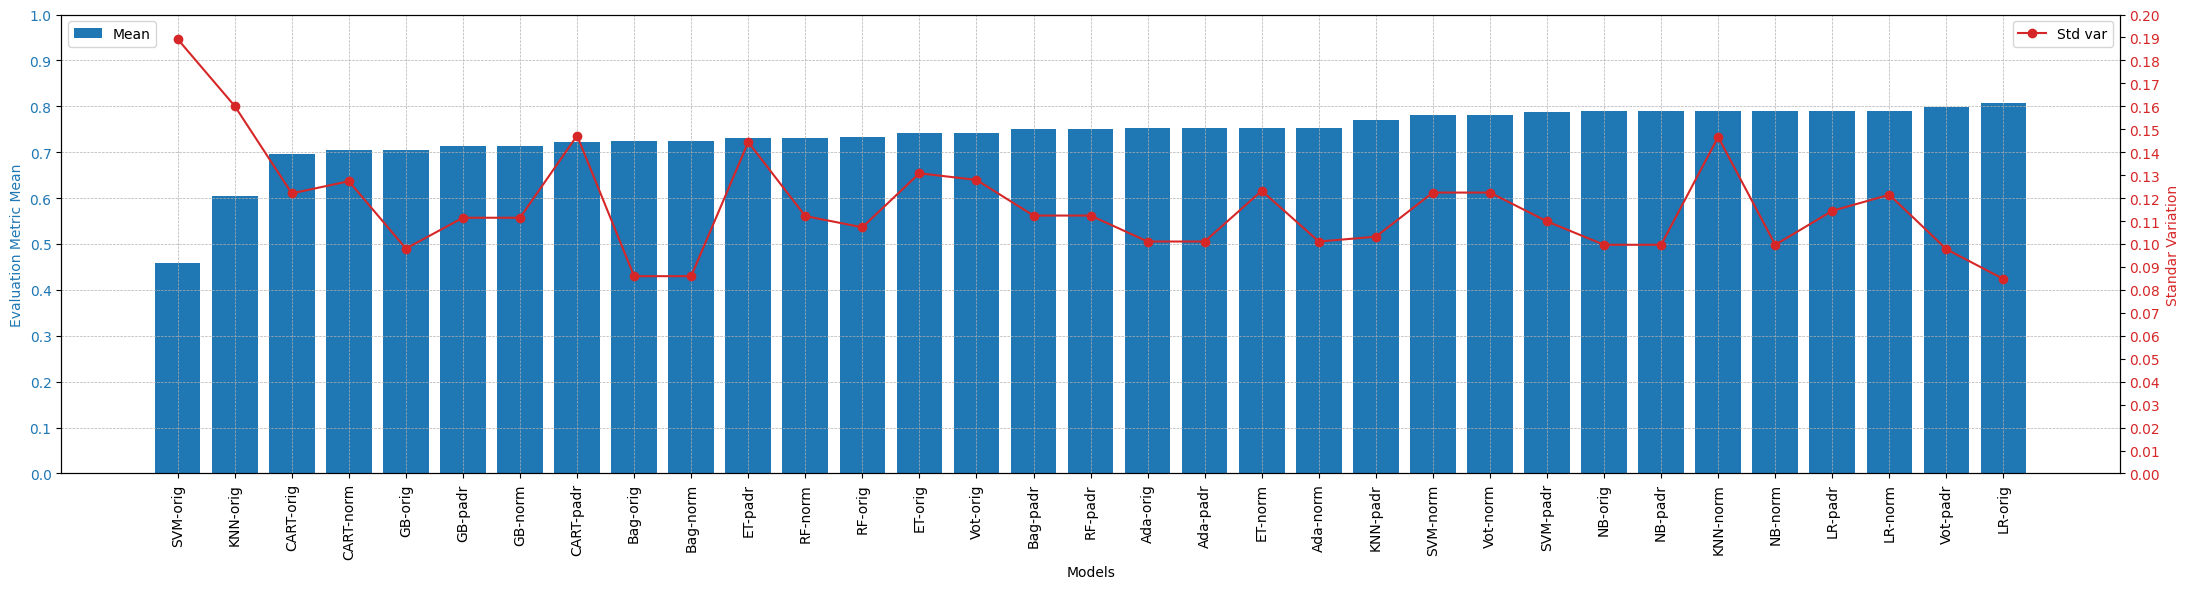

In [26]:
eval_metric_mean_std_plot(pip_results, pip_names)

# Feature Selection

## Univariate Feature Selection using SelectKBest

In [140]:
best_var = SelectKBest()
fit = best_var.fit(X ,y)
features = fit.transform(X)

feature_score_list = list(zip(df_heart_disease.columns.to_list(), fit.scores_))
feature_score_sorted = sorted(feature_score_list, key=lambda x: x[1], reverse=True)
kbst_feature_names_sorted = [t[0] for t in feature_score_sorted]

print(kbst_feature_names_sorted)

['thal', 'ca', 'oldpeak', 'thalach', 'exang', 'cp', 'slope', 'sex', 'age', 'restecg', 'trestbps', 'chol', 'fbs']


In [28]:
np.random.seed(seed)
kbst_pip_names_4, kbst_pip_results_4, kbst_pip_names_7, kbst_pip_results_7, kbst_pip_names_10, kbst_pip_results_10 = cross_validation_with_selected_features(pipelines, df_heart_disease, y, kbst_feature_names_sorted, test_size, seed, ten_folds, scoring)

In [ ]:
print(kbst_feature_names_sorted[0:4])
eval_metric_mean_std_plot(kbst_pip_results_4,  kbst_pip_names_4)

In [ ]:
eval_metric_mean_std_plot(kbst_pip_results_7,  kbst_pip_names_7)

In [ ]:
eval_metric_mean_std_plot(kbst_pip_results_10, kbst_pip_names_10)

## Recursive Feature Elimination

### Logistic Regression Estimator

In [141]:
# @TODO: RFE com estimador sendo regressão logística e SVM

rfe_4_lr = RFE(LogisticRegression(max_iter=max_iter), n_features_to_select=4)
fit_4_lr = rfe_4_lr.fit(X,y)

rfe_7_lr = RFE(LogisticRegression(max_iter=max_iter), n_features_to_select=7)
fit_7_lr = rfe_7_lr.fit(X,y)

rfe_10_lr = RFE(LogisticRegression(max_iter=max_iter), n_features_to_select=10)
fit_10_lr = rfe_10_lr.fit(X,y)

rfe_features_names_lr = fit_4_lr.get_feature_names_out(input_features=df_heart_disease.columns[0:13])

for att in fit_7_lr.get_feature_names_out(input_features=df_heart_disease.columns[0:13]):
  if att not in rfe_features_names_lr:
    rfe_features_names_lr = np.append(rfe_features_names_lr, att)


for att in fit_10_lr.get_feature_names_out(input_features=df_heart_disease.columns[0:13]):
  if att not in rfe_features_names_lr:
    rfe_features_names_lr = np.append(rfe_features_names_lr, att)

print(rfe_features_names_lr)

['sex' 'exang' 'slope' 'ca' 'cp' 'fbs' 'oldpeak' 'restecg' 'thalach'
 'thal']


In [33]:
np.random.seed(seed)
rfe_pip_names_4_lr, rfe_pip_results_4_lr, rfe_pip_names_7_lr, rfe_pip_results_7_lr, rfe_pip_names_10_lr, rfe_pip_results_10_lr = cross_validation_with_selected_features(pipelines, df_heart_disease, y, rfe_features_names_lr, test_size, seed, ten_folds, scoring)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_4_lr, rfe_pip_names_4_lr)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_7_lr, rfe_pip_names_7_lr)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_10_lr, rfe_pip_names_10_lr)

### SVM Estimator

In [142]:
rfe_4_svm = RFE(SVC(kernel='linear'), n_features_to_select=4)
fit_4_svm = rfe_4_svm.fit(X,y)

rfe_7_svm = RFE(SVC(kernel='linear'), n_features_to_select=7)
fit_7_svm = rfe_7_svm.fit(X,y)

rfe_10_svm = RFE(SVC(kernel='linear'), n_features_to_select=10)
fit_10_svm = rfe_10_svm.fit(X,y)

rfe_features_names_svm = fit_4_svm.get_feature_names_out(input_features=df_heart_disease.columns[0:13])

for att in fit_7_svm.get_feature_names_out(input_features=df_heart_disease.columns[0:13]):
  if att not in rfe_features_names_svm:
    rfe_features_names_svm = np.append(rfe_features_names_svm, att)


for att in fit_10_svm.get_feature_names_out(input_features=df_heart_disease.columns[0:13]):
  if att not in rfe_features_names_svm:
    rfe_features_names_svm = np.append(rfe_features_names_svm, att)

print(rfe_features_names_svm)

['fbs' 'exang' 'slope' 'ca' 'sex' 'cp' 'thal' 'restecg' 'thalach'
 'oldpeak']


In [38]:
np.random.seed(seed)
rfe_pip_names_4_svm, rfe_pip_results_4_svm, rfe_pip_names_7_svm, rfe_pip_results_7_svm, rfe_pip_names_10_svm, rfe_pip_results_10_svm = cross_validation_with_selected_features(pipelines, df_heart_disease, y, rfe_features_names_svm, test_size, seed, ten_folds, scoring)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_4_svm, rfe_pip_names_4_svm)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_7_svm, rfe_pip_names_7_svm)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_10_svm, rfe_pip_names_10_svm)

### Random Forest Estimator

In [143]:
rfe_4_rf = RFE(RandomForestClassifier(), n_features_to_select=4)
fit_4_rf = rfe_4_rf.fit(X,y)

rfe_7_rf = RFE(RandomForestClassifier(), n_features_to_select=7)
fit_7_rf = rfe_7_rf.fit(X,y)

rfe_10_rf = RFE(RandomForestClassifier(), n_features_to_select=10)
fit_10_rf = rfe_10_rf.fit(X,y)

rfe_features_names_rf = fit_4_rf.get_feature_names_out(input_features=df_heart_disease.columns[0:13])

for att in fit_7_rf.get_feature_names_out(input_features=df_heart_disease.columns[0:13]):
  if att not in rfe_features_names_rf:
    rfe_features_names_rf = np.append(rfe_features_names_rf, att)


for att in fit_10_rf.get_feature_names_out(input_features=df_heart_disease.columns[0:13]):
  if att not in rfe_features_names_rf:
    rfe_features_names_rf = np.append(rfe_features_names_rf, att)

print(rfe_features_names_rf)

['age' 'thalach' 'oldpeak' 'thal' 'cp' 'chol' 'ca' 'trestbps' 'exang'
 'slope']


In [43]:
np.random.seed(seed)
rfe_pip_names_4_rf, rfe_pip_results_4_rf, rfe_pip_names_7_rf, rfe_pip_results_7_rf, rfe_pip_names_10_rf, rfe_pip_results_10_rf = cross_validation_with_selected_features(pipelines, df_heart_disease, y, rfe_features_names_rf, test_size, seed, ten_folds, scoring)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_4_rf, rfe_pip_names_4_rf)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_7_rf, rfe_pip_names_7_rf)

In [ ]:
eval_metric_mean_std_plot(rfe_pip_results_10_rf, rfe_pip_names_10_rf)

## Attribute Importace

In [144]:
et_feature_importances = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
rf_feature_importances = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
gb_feature_importances = GradientBoostingClassifier(n_estimators=num_trees)
dt_feature_importances = DecisionTreeClassifier()

et_feature_importances = et_feature_importances.fit(X,y)
rf_feature_importances = rf_feature_importances.fit(X,y)
gb_feature_importances = gb_feature_importances.fit(X,y)
dt_feature_importances = dt_feature_importances.fit(X,y)

ai_names_sorted_et = get_features_name_sorted_from_feature_importances(df_heart_disease, et_feature_importances)
ai_names_sorted_rf = get_features_name_sorted_from_feature_importances(df_heart_disease, rf_feature_importances)
ai_names_sorted_gb = get_features_name_sorted_from_feature_importances(df_heart_disease, gb_feature_importances)
ai_names_sorted_dt = get_features_name_sorted_from_feature_importances(df_heart_disease, dt_feature_importances)

In [48]:
np.random.seed(seed)
ai_pip_names_4_et, ai_pip_results_4_et, ai_pip_names_7_et, ai_pip_results_7_et, ai_pip_names_10_et, ai_pip_results_10_et = cross_validation_with_selected_features(pipelines, df_heart_disease, y, ai_names_sorted_et, test_size, seed, ten_folds, scoring)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_4_et, ai_pip_names_4_et)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_7_et, ai_pip_names_7_et)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_10_et, ai_pip_names_10_et)

In [52]:
np.random.seed(seed)
ai_pip_names_4_rf, ai_pip_results_4_rf, ai_pip_names_7_rf, ai_pip_results_7_rf, ai_pip_names_10_rf, ai_pip_results_10_rf = cross_validation_with_selected_features(pipelines, df_heart_disease, y, ai_names_sorted_rf, test_size, seed, ten_folds, scoring)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_4_rf, ai_pip_names_4_rf)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_7_rf, ai_pip_names_7_rf)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_10_rf, ai_pip_names_10_rf)

In [56]:
np.random.seed(seed)
ai_pip_names_4_gb, ai_pip_results_4_gb, ai_pip_names_7_gb, ai_pip_results_7_gb, ai_pip_names_10_gb, ai_pip_results_10_gb = cross_validation_with_selected_features(pipelines, df_heart_disease, y, ai_names_sorted_gb, test_size, seed, ten_folds, scoring)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_4_gb, ai_pip_names_4_gb)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_7_gb, ai_pip_names_7_gb)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_10_gb, ai_pip_names_10_gb)

In [60]:
np.random.seed(seed)
ai_pip_names_4_dt, ai_pip_results_4_dt, ai_pip_names_7_dt, ai_pip_results_7_dt, ai_pip_names_10_dt, ai_pip_results_10_dt = cross_validation_with_selected_features(pipelines, df_heart_disease, y, ai_names_sorted_dt, test_size, seed, ten_folds, scoring)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_4_dt, ai_pip_names_4_dt)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_7_dt, ai_pip_names_7_dt)

In [ ]:
eval_metric_mean_std_plot(ai_pip_results_10_dt, ai_pip_names_10_dt)

# Hyper Parameter Optimization

In [122]:
pipelines_as_dict = dict(pipelines)

In [135]:
pipeline_data = [(name, np.mean(arr), np.std(arr), 'none', pipelines_as_dict[name], ['']) for name, arr in zip(pip_names, pip_results)]

pipeline_data_sorted = sorted(pipeline_data, key=lambda x: x[1], reverse=True)

In [145]:
kbest_data =  [(name, np.mean(results), np.std(results), 'select_kbest_4',  pipelines_as_dict[name], kbst_feature_names_sorted) for name, results in zip(kbst_pip_names_4,  kbst_pip_results_4)]
kbest_data += [(name, np.mean(results), np.std(results), 'select_kbest_7',  pipelines_as_dict[name], kbst_feature_names_sorted) for name, results in zip(kbst_pip_names_7,  kbst_pip_results_7)]
kbest_data += [(name, np.mean(results), np.std(results), 'select_kbest_10', pipelines_as_dict[name], kbst_feature_names_sorted) for name, results in zip(kbst_pip_names_10, kbst_pip_results_10)]

kbest_data_sorted = sorted(kbest_data, key=lambda x: x[1], reverse=True)

In [146]:
rfe_data_lr =  [(name, np.mean(results), np.std(results), 'rfe_lr_4',  pipelines_as_dict[name], rfe_features_names_lr) for name, results in zip(rfe_pip_names_4_lr,  rfe_pip_results_4_lr)]
rfe_data_lr += [(name, np.mean(results), np.std(results), 'rfe_lr_7',  pipelines_as_dict[name], rfe_features_names_lr) for name, results in zip(rfe_pip_names_7_lr,  rfe_pip_results_7_lr)]
rfe_data_lr += [(name, np.mean(results), np.std(results), 'rfe_lr_10', pipelines_as_dict[name], rfe_features_names_lr) for name, results in zip(rfe_pip_names_10_lr, rfe_pip_results_10_lr)]

rfe_data_lr_sorted = sorted(rfe_data_lr, key=lambda x: x[1], reverse=True)

In [147]:
rfe_data_svm =  [(name, np.mean(results), np.std(results), 'rfe_svm_4',  pipelines_as_dict[name], rfe_features_names_svm) for name, results in zip(rfe_pip_names_4_svm,  rfe_pip_results_4_svm)]
rfe_data_svm += [(name, np.mean(results), np.std(results), 'rfe_svm_7',  pipelines_as_dict[name], rfe_features_names_svm) for name, results in zip(rfe_pip_names_7_svm,  rfe_pip_results_7_svm)]
rfe_data_svm += [(name, np.mean(results), np.std(results), 'rfe_svm_10', pipelines_as_dict[name], rfe_features_names_svm) for name, results in zip(rfe_pip_names_10_svm, rfe_pip_results_10_svm)]

rfe_data_svm_sorted = sorted(rfe_data_svm, key=lambda x: x[1], reverse=True)

In [148]:
rfe_data_rf =  [(name, np.mean(results), np.std(results), 'rfe_rf_4',  pipelines_as_dict[name], rfe_features_names_rf) for name, results in zip(rfe_pip_names_4_rf,  rfe_pip_results_4_rf)]
rfe_data_rf += [(name, np.mean(results), np.std(results), 'rfe_rf_7',  pipelines_as_dict[name], rfe_features_names_rf) for name, results in zip(rfe_pip_names_7_rf,  rfe_pip_results_7_rf)]
rfe_data_rf += [(name, np.mean(results), np.std(results), 'rfe_rf_10', pipelines_as_dict[name], rfe_features_names_rf) for name, results in zip(rfe_pip_names_10_rf, rfe_pip_results_10_rf)]

rfe_data_rf_sorted = sorted(rfe_data_rf, key=lambda x: x[1], reverse=True)

In [149]:
ai_data_et =  [(name, np.mean(results), np.std(results), 'ai_et_4',  pipelines_as_dict[name], ai_names_sorted_et) for name, results in zip(ai_pip_names_4_et,  ai_pip_results_4_et)]
ai_data_et += [(name, np.mean(results), np.std(results), 'ai_et_7',  pipelines_as_dict[name], ai_names_sorted_et) for name, results in zip(ai_pip_names_7_et,  ai_pip_results_7_et)]
ai_data_et += [(name, np.mean(results), np.std(results), 'ai_et_10', pipelines_as_dict[name], ai_names_sorted_et) for name, results in zip(ai_pip_names_10_et, ai_pip_results_10_et)]

ai_data_et_sorted = sorted(ai_data_et, key=lambda x: x[1], reverse=True)

In [150]:
ai_data_rf =  [(name, np.mean(results), np.std(results), 'ai_rf_4',  pipelines_as_dict[name], ai_names_sorted_rf) for name, results in zip(ai_pip_names_4_rf,  ai_pip_results_4_rf)]
ai_data_rf += [(name, np.mean(results), np.std(results), 'ai_rf_7',  pipelines_as_dict[name], ai_names_sorted_rf) for name, results in zip(ai_pip_names_7_rf,  ai_pip_results_7_rf)]
ai_data_rf += [(name, np.mean(results), np.std(results), 'ai_rf_10', pipelines_as_dict[name], ai_names_sorted_rf) for name, results in zip(ai_pip_names_10_rf, ai_pip_results_10_rf)]

ai_data_rf_sorted = sorted(ai_data_rf, key=lambda x: x[1], reverse=True)

In [151]:
ai_data_gb =  [(name, np.mean(results), np.std(results), 'ai_gb_4',  pipelines_as_dict[name], ai_names_sorted_gb) for name, results in zip(ai_pip_names_4_gb,  ai_pip_results_4_gb)]
ai_data_gb += [(name, np.mean(results), np.std(results), 'ai_gb_7',  pipelines_as_dict[name], ai_names_sorted_gb) for name, results in zip(ai_pip_names_7_gb,  ai_pip_results_7_gb)]
ai_data_gb += [(name, np.mean(results), np.std(results), 'ai_gb_10', pipelines_as_dict[name], ai_names_sorted_gb) for name, results in zip(ai_pip_names_10_gb, ai_pip_results_10_gb)]

ai_data_gb_sorted = sorted(ai_data_gb, key=lambda x: x[1], reverse=True)

In [152]:
ai_data_dt =  [(name, np.mean(results), np.std(results), 'ai_dt_4',  pipelines_as_dict[name], ai_names_sorted_dt) for name, results in zip(ai_pip_names_4_dt,  ai_pip_results_4_dt)]
ai_data_dt += [(name, np.mean(results), np.std(results), 'ai_dt_7',  pipelines_as_dict[name], ai_names_sorted_dt) for name, results in zip(ai_pip_names_7_dt,  ai_pip_results_7_dt)]
ai_data_dt += [(name, np.mean(results), np.std(results), 'ai_dt_10', pipelines_as_dict[name], ai_names_sorted_dt) for name, results in zip(ai_pip_names_10_dt, ai_pip_results_10_dt)]

ai_data_dt_sorted = sorted(ai_data_dt, key=lambda x: x[1], reverse=True)

In [155]:
best_models_selected = pipeline_data_sorted[0:5] + kbest_data_sorted[0:5] + rfe_data_lr_sorted[0:5] + rfe_data_svm_sorted[0:5] + rfe_data_rf_sorted[0:5] + ai_data_et_sorted[0:5] + ai_data_rf_sorted[0:5] + ai_data_gb_sorted[0:5] + ai_data_dt_sorted[0:5]

df_all_models_results = pd.DataFrame(best_models_selected, columns=['name', 'mean', 'std', 'feature_selection', 'model', 'features_selected'])
df_all_models_results

,name,mean,std,feature_selection,model,features_selected
0,LR-orig,0.808182,0.084741,none,(LogisticRegression(max_iter=200)),[]
1,Vot-padr,0.798182,0.097726,none,"(StandardScaler(), VotingClassifier(estimators...",[]
2,LR-padr,0.790000,0.114448,none,"(StandardScaler(), LogisticRegression(max_iter...",[]
3,LR-norm,0.790000,0.121455,none,"(MinMaxScaler(), LogisticRegression(max_iter=2...",[]
4,NB-orig,0.789091,0.099652,none,(GaussianNB()),[]
5,NB-orig,0.854545,0.109091,select_kbest_4,(GaussianNB()),"[thal, ca, oldpeak, thalach, exang, cp, slope,..."
6,NB-padr,0.854545,0.109091,select_kbest_4,"(StandardScaler(), GaussianNB())","[thal, ca, oldpeak, thalach, exang, cp, slope,..."
7,NB-norm,0.854545,0.109091,select_kbest_4,"(MinMaxScaler(), GaussianNB())","[thal, ca, oldpeak, thalach, exang, cp, slope,..."
8,LR-norm,0.809091,0.118182,select_kbest_4,"(MinMaxScaler(), LogisticRegression(max_iter=2...","[thal, ca, oldpeak, thalach, exang, cp, slope,..."
9,SVM-norm,0.809091,0.118182,select_kbest_4,"(MinMaxScaler(), SVC())","[thal, ca, oldpeak, thalach, exang, cp, slope,..."


In [190]:
# LR: C, penalty, solver
# SVM: C, kernel, gamma
# KNN: n_neighbors, weights, algorithm

np.random.seed(seed)

lr_param_grid = {
    'LR__penalty': ['l1', 'l2', 'elasticnet', None],
    'LR__C': [1, 2, 3, 4],
    'LR__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'LR__max_iter': [100, 200, 300, 400]
}
svm_param_grid = {
    'SVM__kernel': ['linear', 'rbf'],
    'SVM__C': [1, 2, 3, 4],
    'SVM__gamma': ['scale', 'auto'],
    'SVM__degree': [2, 3, 4, 5]
}
knn_param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"]
}

grid = GridSearchCV(estimator=df_all_models_results.iloc[11]['model'], param_grid=knn_param_grid, scoring=scoring, cv=ten_folds)
grid.fit(X_train, y_train)
# imprime a melhor configuração
print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (df_all_models_results.iloc[11]['name'], grid.best_score_, grid.best_params_))


grid = GridSearchCV(estimator=df_all_models_results.iloc[18]['model'], param_grid=svm_param_grid, scoring=scoring, cv=ten_folds)
grid.fit(X_train, y_train)
# imprime a melhor configuração
print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (df_all_models_results.iloc[18]['name'], grid.best_score_, grid.best_params_))



grid = GridSearchCV(estimator=df_all_models_results.iloc[0]['model'], param_grid=lr_param_grid, scoring=scoring, cv=ten_folds)
grid.fit(X_train, y_train)
# imprime a melhor configuração
print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (df_all_models_results.iloc[0]['name'], grid.best_score_, grid.best_params_))

Sem tratamento de missings: KNN-norm - Melhor: 0.807273 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1}
Sem tratamento de missings: SVM-padr - Melhor: 0.797273 usando {'SVM__C': 3, 'SVM__degree': 2, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Sem tratamento de missings: LR-orig - Melhor: 0.809091 usando {'LR__C': 1, 'LR__max_iter': 300, 'LR__penalty': None, 'LR__solver': 'lbfgs'}


In [189]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

for i, (name, _, _, feature_selection, model, features_selected) in df_all_models_results.iterrows():
  if feature_selection == "none":
    X_train_grid = X_train
    y_train_grid = y_train
  else:

  #@TODO: PAREI AQUI, RECÉM ME DEI CONTA DE QUE A QUESTÃO DO NORM OU PADR JÁ ESTÁ RESOLVIDA NO PIPELINE
  # AGORA TEM QUE PEGAR OS ARRAYS X_TEST CORRETOS PARA CADA TIPO DE FEATURE SELECTION DE ACORDO COM O NÚMERO DE
  # FEATURES SELECIONADAS


  grid = GridSearchCV(estimator=model)
  break

0
LR-orig
none
Pipeline(steps=[('LR', LogisticRegression(max_iter=200))])
['']


In [161]:
df_all_models_results.iloc[11]['model']

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('KNN', KNeighborsClassifier())])

# Correlation Matrix Tests

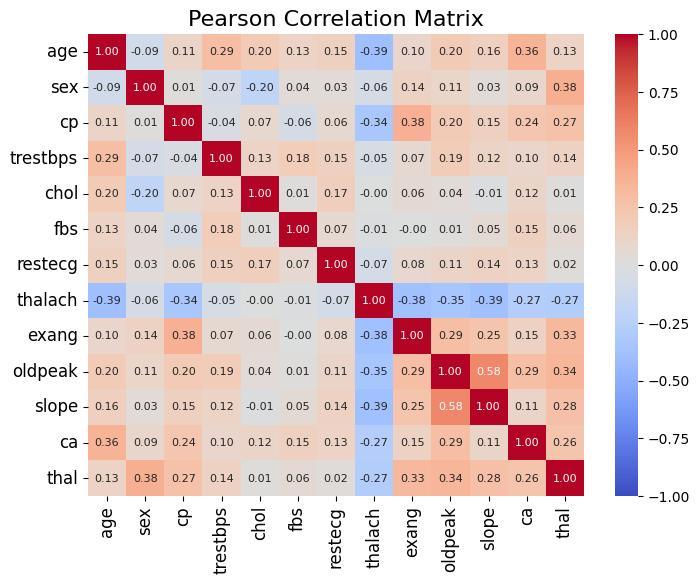

In [64]:
corr_matrix  = df_heart_disease.iloc[:, :13].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 8})
plt.title('Pearson Correlation Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 'sex' 'exang' 'slope' 'ca'


In [73]:
import pandas as pd

# Sample lists
string_lists = [
    ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10'],
    ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10'],
    ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10'],
    ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10']
]

float_lists = [
    [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9, 10.0],
    [10.0, 9.9, 8.8, 7.7, 6.6, 5.5, 4.4, 3.3, 2.2, 1.1],
    [5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9],
    [7.0, 6.9, 6.8, 6.7, 6.6, 6.5, 6.4, 6.3, 6.2, 6.1]
]

# Initialize an empty list to store the data
data = []

# Loop through the lists to create the dataframe
for i, (strings, floats) in enumerate(zip(string_lists, float_lists)):
    mean_value = pd.Series(floats).mean()
    std_value = pd.Series(floats).std()
    col1 = f"list_{i + 1}"
    col2 = bool(i % 2)  # Alternate True and False

    for name in strings:
        data.append([name, mean_value, std_value, col1, col2])

# Create the dataframe
df = pd.DataFrame(data, columns=['name', 'mean', 'std', 'col1', 'col2'])

print(df)


   name  mean       std    col1   col2
0    a1  5.95  3.176738  list_1  False
1    a2  5.95  3.176738  list_1  False
2    a3  5.95  3.176738  list_1  False
3    a4  5.95  3.176738  list_1  False
4    a5  5.95  3.176738  list_1  False
5    a6  5.95  3.176738  list_1  False
6    a7  5.95  3.176738  list_1  False
7    a8  5.95  3.176738  list_1  False
8    a9  5.95  3.176738  list_1  False
9   a10  5.95  3.176738  list_1  False
10   b1  5.95  3.176738  list_2   True
11   b2  5.95  3.176738  list_2   True
12   b3  5.95  3.176738  list_2   True
13   b4  5.95  3.176738  list_2   True
14   b5  5.95  3.176738  list_2   True
15   b6  5.95  3.176738  list_2   True
16   b7  5.95  3.176738  list_2   True
17   b8  5.95  3.176738  list_2   True
18   b9  5.95  3.176738  list_2   True
19  b10  5.95  3.176738  list_2   True
20   c1  5.45  0.302765  list_3  False
21   c2  5.45  0.302765  list_3  False
22   c3  5.45  0.302765  list_3  False
23   c4  5.45  0.302765  list_3  False
24   c5  5.45  0.302765  